<a href="https://colab.research.google.com/github/Thujaina/NIT-Internship/blob/main/tversky_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install imblearn

In [2]:
!pip install seaborn

In [3]:
!pip install -U tensorflow scikeras imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 136.9 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is in

In [4]:
!pip install scikeras

In [5]:
!pip install -U scikit-learn scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
TRAIN_PATH = "/content/drive/MyDrive/datasets/ECG/mitbih_train.csv"
TEST_PATH  = "/content/drive/MyDrive/datasets/ECG/mitbih_test.csv"

train = pd.read_csv(TRAIN_PATH, header=None)
test  = pd.read_csv(TEST_PATH, header=None)

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (87554, 188)
Test shape: (21892, 188)


In [9]:
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]


In [10]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)


In [11]:
y_res_cat  = to_categorical(y_res, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_res, y_res_cat, test_size=0.2, random_state=0
)


In [13]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred, axis=1)
    fp = tf.reduce_sum((1 - y_true) * y_pred, axis=1)
    fn = tf.reduce_sum(y_true * (1 - y_pred), axis=1)

    tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
    return 1 - tf.reduce_mean(tversky)


In [14]:
def ann_model():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(64, activation="relu"),
        Dense(5, activation="sigmoid")  # OvR multi-class
    ])

    model.compile(
        optimizer="adam",
        loss=tversky_loss,
        metrics=["accuracy"]
    )

    return model


In [15]:
model = ann_model()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)


Epoch 1/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7861 - loss: 0.2373 - val_accuracy: 0.8847 - val_loss: 0.1162
Epoch 2/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8959 - loss: 0.1060 - val_accuracy: 0.9119 - val_loss: 0.0886
Epoch 3/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9145 - loss: 0.0853 - val_accuracy: 0.9193 - val_loss: 0.0794
Epoch 4/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9262 - loss: 0.0743 - val_accuracy: 0.9361 - val_loss: 0.0679
Epoch 5/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9337 - loss: 0.0669 - val_accuracy: 0.9449 - val_loss: 0.0574
Epoch 6/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9467 - loss: 0.0562 - val_accuracy: 0.9516 - val_loss: 0.0516
Epoch 7/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9518 - loss: 0.0508 - val_accuracy: 0.9546 - val_loss: 0.0478
Epoch 8/10
4530/4530 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9554 - loss: 0

In [16]:
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

mcc = matthews_corrcoef(
    y_val.argmax(axis=1),
    y_val_pred.argmax(axis=1)
)

print("Validation MCC:", mcc)


2265/2265 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Validation MCC: 0.9569593916494528


In [17]:
test_predictions = (model.predict(X_test) > 0.5).astype(int)
test_loss, test_acc = model.evaluate(X_test, y_test_cat)

print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9557 - loss: 0.0477
Test Accuracy: 0.9512607455253601
Test Loss: 0.051399752497673035


In [18]:
print(
    classification_report(
        y_test_cat.argmax(axis=1),
        test_predictions.argmax(axis=1)
    )
)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18118
           1       0.59      0.77      0.66       556
           2       0.89      0.92      0.91      1448
           3       0.42      0.87      0.57       162
           4       0.98      0.97      0.98      1608

    accuracy                           0.96     21892
   macro avg       0.77      0.90      0.82     21892
weighted avg       0.97      0.96      0.96     21892



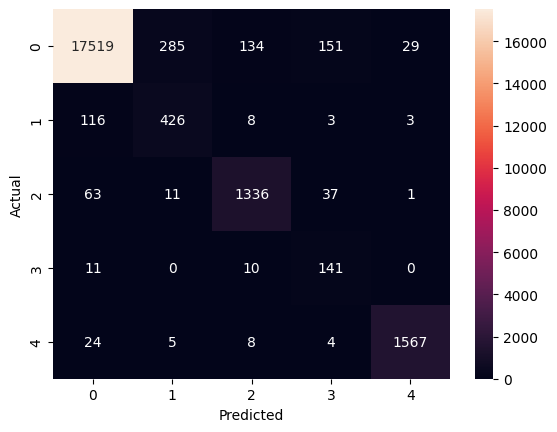

In [19]:
cm = confusion_matrix(
    y_test_cat.argmax(axis=1),
    test_predictions.argmax(axis=1)
)

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

acc_scores = []
mcc_scores = []
fold = 1

for train_idx, val_idx in kfold.split(X_res):
    print(f"\n🔁 Fold {fold}")

    X_tr, X_va = X_res.iloc[train_idx], X_res.iloc[val_idx]
    y_tr, y_va = y_res_cat[train_idx], y_res_cat[val_idx]

    model = ann_model()
    model.fit(X_tr, y_tr, epochs=10, batch_size=64, verbose=0)

    val_pred = (model.predict(X_va) > 0.5).astype(int)

    acc = np.mean(val_pred.argmax(axis=1) == y_va.argmax(axis=1))
    mcc = matthews_corrcoef(
        y_va.argmax(axis=1),
        val_pred.argmax(axis=1)
    )

    acc_scores.append(acc)
    mcc_scores.append(mcc)

    print(f"Accuracy: {acc:.4f}")
    print(f"MCC: {mcc:.4f}")

    fold += 1

print("\n✅ Cross-Validation Results")
print("Accuracy per fold:", acc_scores)
print("Mean Accuracy:", np.mean(acc_scores))
print("MCC per fold:", mcc_scores)
print("Mean MCC:", np.mean(mcc_scores))



🔁 Fold 1
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step
Accuracy: 0.9642
MCC: 0.9554

🔁 Fold 2
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 2s 813us/step
Accuracy: 0.9556
MCC: 0.9450

🔁 Fold 3
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 2s 817us/step
Accuracy: 0.9615
MCC: 0.9521

🔁 Fold 4
2831/2831 ━━━━━━━━━━━━━━━━━━━━ 2s 809us/step
Accuracy: 0.9655
MCC: 0.9569

✅ Cross-Validation Results
Accuracy per fold: [np.float64(0.9642119904182627), np.float64(0.9556237512280741), np.float64(0.961507467794103), np.float64(0.9654810791716342)]
Mean Accuracy: 0.9617060721530185
MCC per fold: [0.9554148719459101, 0.94498041900762, 0.9521079425055795, 0.9568970209628863]
Mean MCC: 0.952350063605499
